This is (still) the sixth simple toy model to adapt the LLH NN from Ice Cube to tracker geometry. We're using a more realistic detector model now with 32 detector layers separated into 32 bins. The layers are stacked straight, not following the curve of the ring, and tracks are curved. Each bin only registers hit/no hit, with 100% efficiency. Instead of using (z,p,phi), we are now using (x,z,p) and assume that phi=0 always. Hits are NOT Gaussian distributed anymore. 

Thus, the analytic probility would just be a delta function and the likelihood becomes either 1 or 0, if all the right straws are hit or not respectively. We will only look at the NN output.

Training on large parameter range with 1e6 samples. We'll draw the samples here from a truncated Gaussian distribution and compare to uniform distribution in v2.3.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import types
from scipy.optimize import minimize, Bounds

from LLH_NN_utils import *

In [2]:
#layers at fixed z, giving x position
#source has x,z,px,pz
# B=1.45

#each tracker module has 4 layers of 32 straws, 8 modules in a station
#straw tube is 5mm diameter
#muons decay 5-10m from first layer
#momentum (0.5-3)e3 MeV
#300 mu-m radial position resolution
#4cm between outer layers of one module
#~6cm from center of module to edge?
#1mm between the two U-layers


#layers of 32 5mm bins, 1mm separated, 1cm between "twin" layers
#
# __ __ __ __
#__ __ __ __
#
#__ __ __ __
# __ __ __ __

#2cm between U and V, 4cm between modules

det_zs = np.ones((8,4))
det_zs[:,0] *= 0
det_zs[:,2] *= 3
det_zs[:,3] *= 4
for i in range(1,8):
    det_zs[i] += i*8
det_zs = det_zs.flatten()*1e-2
    
N_bins = 32
N_det = len(det_zs)

det_xs = np.tile(np.array([(i*6+2.5)*1e-3 for i in range(32)]),(N_det,1)) #i = z, j = x
#leftshift_idx = [1,2,5,6,9,10,13,14] #i//2 even and i%2 odd or i//2 odd and i%2 even
det_xs[[((i//2)%2 == 0 and (i%2) == 1) or ((i//2)%2 == 1 and (i%2) == 0) for i in range(N_det)]] -= 2.5e-3
det_xs += (4.5 + 2)*1e-2 #distance to storage volume center

### Tracker toy model

Muon decaying at (x,z), producing positron with momentum p in z-direction. $\vec{B} = B\hat{y}$

Since the Lorentz force only acts perpendicular to the direction of motion, $|v|$ and $\gamma$ don't change, and the time derivative is simply
$\frac{d\vec{v}}{dt} = \frac{q}{\gamma m} (\vec{v} \times \vec{B}) = \frac{qB}{\gamma m} (v_x \hat{z} - v_z\hat{x})$

$p_x = p\sin(\frac{qB}{\gamma m} t)$<br/>
$p_z = p\cos(\frac{qB}{\gamma m} t)$

$x = \int_0^T v_x dt = -\frac{\gamma m}{qB} |v| (\cos(\frac{qB}{\gamma m} T) - \frac{v_z(0)}{|v|})$<br/>
$z = \int_0^T v_z dt = \frac{\gamma m}{qB} |v| (\sin(\frac{qB}{\gamma m} T) - \frac{v_x(0)}{|v|})$

$z$ is fixed, so<br/>
$T = \frac{\gamma m}{qB}\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})$

$x = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\cos(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})) = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\sqrt{1 - (\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})^2} = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2|v|^2 - (qBz +\gamma mv_x(0))^2}$<br/>
$x = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2v_z^2(0) - q^2B^2z^2 -2qBz\gamma mv_x(0)} = \frac{p_z(0)}{qB} - \frac{1}{qB}\sqrt{p_z^2(0) - q^2B^2z^2 -2qBzp_x(0)}$

Change to use $|p|(0) = p$ and initial angle $\phi = 0$ (from the z-axis):<br/>
$x = \frac{p}{qB} - \frac{1}{qB}\sqrt{p^2 - q^2B^2z^2} + x(0) = \frac{p}{qB}(1 - \sqrt{1 - \frac{q^2B^2z^2}{p^2}}) + x(0)$

In [3]:
#leave out e in momentum calc, and q's above

c = constants.c
#e = constants.e
B = 1.45

def calc_x(x,z,p):
    # p is in GeV -> *1e9/c
    p = p*1e9/c
    
    sq = p**2 - B**2*z**2
    #take square root where possible
    sq[sq>=0] = np.sqrt(sq[sq>=0])
    
    res = (p - sq)/B + x
    res[sq<0] = -1

    return res

#example event x_toy,z_toy,p_toy
toy=[1e-3,-0.73,1.9] #this produces hits in almost every layer
#toy=[-1e-2,-0.64,2.3] #this is a flat event, leaving top layers w/o hits
x_toy, z_toy, p_toy = toy

In [4]:
def generate_event(x, z, p):
    # generates an event from given x, z, p
    # returns N_det x 2 array of centers of hit bins and z-position of layer
    
    hits = np.zeros((N_det,2))
    hits[:,1] = det_zs
    dist = det_zs-z
    x_exp = calc_x(x,dist,p)
    for i in range(N_det):
        #check if x_exp < or > than end of detector (incl. -1)
        if x_exp[i] < det_xs[i,0]-2.5e-3 or x_exp[i] > det_xs[i,-1]+2.5e-3: continue
        
        #figure out which bin it would hit
        j = (np.abs(det_xs[i] - x_exp[i])).argmin()
        if np.abs(x_exp[i]-det_xs[i,j]) <= 2.5e-3:
            hits[i,0] = det_xs[i,j]
    return hits

#toy MC
def MC_events(N_events, verbose_lvl = 0):
    '''
    sample source parameters from truncated Gaussian distribution of x, z, and p
    and generate events using those.
    N_events : int
        number of desired events
        
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array x,z,p
    # p is in GeV -> *1e9/c
    
    x = []
    z = []
    p = []
    events = []
    
    while len(events)<N_events:
        # number of events to go
        n_evs = N_events-len(events)
        if verbose_lvl == 2:
            print("# events done:",len(events))
            print("# events to go:",n_evs)
        _x = stats.truncnorm(-4.5,4.5,scale=0.01).rvs(n_evs) #draw between -4.5 and 4.5 cm
        _z = stats.truncnorm(-4,3,loc=-0.8,scale=0.1).rvs(n_evs)  #draw between -1.2 and -0.5 m
        _p = stats.truncnorm(-1.9/0.6,1.6/0.6,loc=1.9,scale=0.6).rvs(n_evs)  #draw between 0.5 and 3.5 GeV
        #_p = stats.skewnorm(5,loc=0.7).rvs()  #alternatively if we want more realistic p distribution

        for i in range(n_evs):
            _ev = generate_event(_x[i],_z[i],_p[i])
        
            #check if particle produces at least 5 hits (3 layers)
            if np.sum(_ev[:,0]>0)>4:
                x.append(_x[i])
                z.append(_z[i])
                p.append(_p[i])
                events.append(_ev)
                if verbose_lvl >= 1:
                    if len(events)%(N_events//10) == 0: print(N_events//10,"events done")
        if verbose_lvl == 2:
            print("# events thrown out:",N_events - len(events))
    
    truth = np.asarray([x, z, p]).T
    assert truth.shape[0] == len(events)
        
    return events, truth

In [5]:
def plot_event(ev):
    #plt scatter, then scatter event in red on top
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for i in range(N_det):
        ax.scatter(det_xs[i],np.ones(N_bins)*det_zs[i],marker="_",s=100,color="grey")
    ax.scatter(ev[:,0][ev[:,0]>0],det_zs[ev[:,0]>0],marker="_",s=100,color="red")

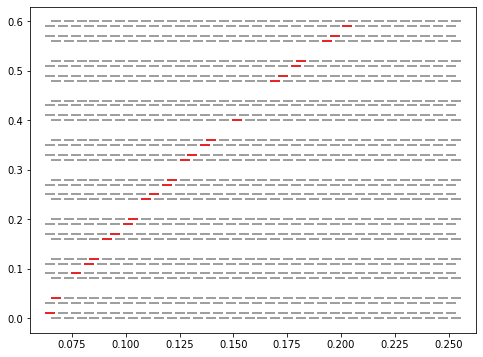

In [6]:
ev = generate_event(*toy)
#print(ev)
plot_event(ev)

In [7]:
#make toy MC data for neural net training
N_mc = int(1e6)
mc, truth = MC_events(N_mc,verbose_lvl=2)

# events done: 0
# events to go: 1000000
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
# events thrown out: 30724
# events done: 969276
# events to go: 30724
# events thrown out: 942
# events done: 999058
# events to go: 942
# events thrown out: 26
# events done: 999974
# events to go: 26
100000 events done
# events thrown out: 0


In [8]:
#neural nets

hitnet = types.SimpleNamespace() 

hitnet.events = mc

#count number of non-zero hits
n_hits_per_event = []
for item in mc:
    n_hits_per_event.append(np.sum(item[:,0]>0))

#separate the hits into single events, add number of non-zero hits
hitnet.events = np.concatenate(hitnet.events)
n_hits_per_event = np.array(n_hits_per_event)
hitnet.events = np.vstack((hitnet.events.T,np.repeat(n_hits_per_event,N_det))).T

hitnet.truth = np.repeat(truth, N_det, axis=0)

assert hitnet.events.shape[0] == hitnet.truth.shape[0]

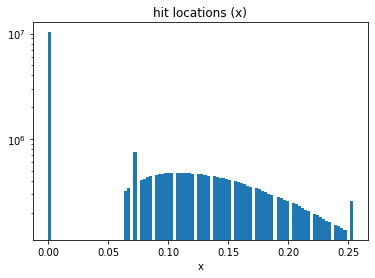

In [9]:
plt.hist(hitnet.events[:,0], bins=100)#[hitnet.events[:,0]>0]
plt.gca().set_yscale('log')
plt.title('hit locations (x)')
plt.xlabel('x')
plt.show()

In [10]:
#need trafo to combine measurements and (hypothetical) input params into input for NN
class trafo(tf.keras.layers.Layer):

    def call(self, hits, theta):
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 #hits[:,2],
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )
        return out

hitnet.trafo = trafo

In [11]:
#make training and test datasets
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)
hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)

In [12]:
## Neural Net

activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

#h = tf.keras.layers.Dense(16, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(16, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo (trafo)                   (None, 5)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           192         trafo[0][0]                  

In [13]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [14]:
#training

hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=5, verbose=1, validation_data=hitnet.d_test)

Epoch 1/5
12500/12500 [==============================] - 695s 56ms/step - loss: 0.3459 - val_loss: 0.2729
Epoch 2/5
12500/12500 [==============================] - 686s 55ms/step - loss: 0.2933 - val_loss: 0.2871
Epoch 3/5
12500/12500 [==============================] - 648s 52ms/step - loss: 0.2792 - val_loss: 0.2570
Epoch 4/5
12500/12500 [==============================] - 636s 51ms/step - loss: 0.2751 - val_loss: 0.2539
Epoch 5/5
12500/12500 [==============================] - 685s 55ms/step - loss: 0.2703 - val_loss: 0.2714


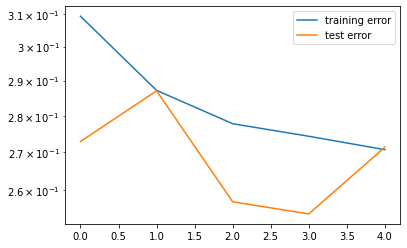

In [15]:
plt.plot(hitnet.model.history.history['loss'],label='training error')
plt.plot(hitnet.model.history.history['val_loss'],label='test error')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

#compile neural net
#log(sigmoid) = linear -> change last layer to get llh
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

In [16]:
grid_spacing = 100

#full range
xs = np.linspace(-2.5e-2, 2.5e-2, grid_spacing)
zs = np.linspace(-1, -0.5, grid_spacing)
ps = np.linspace(0.5, 3.0, grid_spacing)

In [17]:
len_ev = np.sum(ev[:,0]>0)

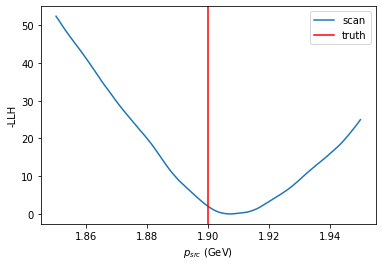

In [21]:
#neural net scan
p_zoom = np.array([-0.05,0.05]) + p_toy #0.1
ps = np.linspace(*p_zoom, grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*x_toy,np.ones(grid_spacing)*z_toy,ps]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev[:,0],grid_spacing)
scan_x = np.vstack((scan_x,np.tile(ev[:,1],grid_spacing),len_ev*np.ones(grid_spacing*N_det))).T

nn_p_scan = hitnet.llh.predict([scan_x,scan_t])

nn_p_scan = -np.sum(nn_p_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_p_scan, ps, p_toy, axis_label='$p_{src}$ (GeV)')

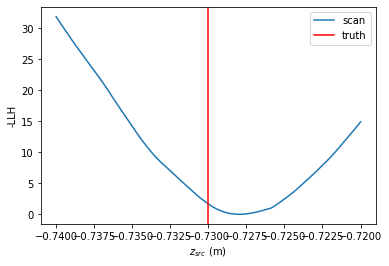

In [22]:
#neural net scan
z_zoom = np.array([-0.01,0.01]) + z_toy #0.015
zs = np.linspace(*z_zoom, grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*x_toy,zs,np.ones(grid_spacing)*p_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_z_scan = hitnet.llh.predict([scan_x,scan_t])

nn_z_scan = -np.sum(nn_z_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_z_scan, zs, z_toy, axis_label='$z_{src}$ (m)')

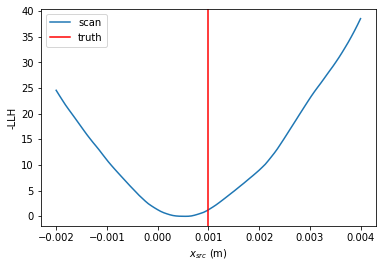

In [23]:
#neural net scan
x_zoom = np.array([-0.003,0.003]) + x_toy
xs = np.linspace(*x_zoom, grid_spacing)

scan_t = np.vstack([xs,np.ones(grid_spacing)*z_toy,np.ones(grid_spacing)*p_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_x_scan = hitnet.llh.predict([scan_x,scan_t])

nn_x_scan = -np.sum(nn_x_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_x_scan, xs, x_toy, axis_label='$x_{src}$ (m)')

Full range scans (and distribution of x hits) show similar shapes to samples drawn from uniform distributions. When adding the number of non zero hits feature, shapes change noticably.

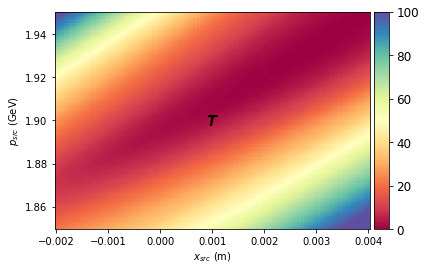

In [24]:
#neural net scan
mg = np.meshgrid(xs,ps)

hitnet.grid_t = np.vstack([mg[0].flatten(),np.ones(grid_spacing**2)*z_toy,mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev[:,0],grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(ev[:,1],grid_spacing**2),len_ev*np.ones(grid_spacing**2*N_det))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_x_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_x_p_scan, xs, ps, x_toy, p_toy, 
            axis_labels=['$x_{src}$ (m)','$p_{src}$ (GeV)'], vmax=100)

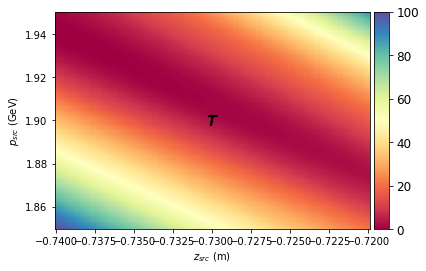

In [25]:
#neural net scan
mg = np.meshgrid(zs,ps)

hitnet.grid_t = np.vstack([np.ones(grid_spacing**2)*x_toy,mg[0].flatten(),mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_p_scan, zs, ps, z_toy, p_toy, 
            axis_labels=['$z_{src}$ (m)', '$p_{src}$ (GeV)'], vmax=100)

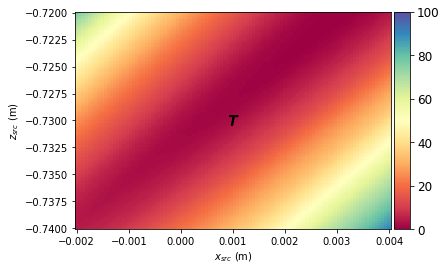

In [26]:
#neural net scan
mg = np.meshgrid(xs,zs)

hitnet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*p_toy]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_x_z_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_x_z_scan, xs, zs, x_toy, z_toy, 
            axis_labels=['$x_{src}$ (m)', '$z_{src}$ (m)'], vmax=100)

In [31]:
#minimize nn output
def llh_fct(theta,event):
    #wrapper function

    #event is nx2 array
    len_ev = np.sum(event[:,0]>0)
    
    #repeat truth for each hit in event
    params = np.tile(theta,len(event)).reshape((len(event),-1)) 
    #add number of nonzero events
    obs = np.vstack((event.T,len_ev*np.ones(len(event)))).T
    
    #let neural net predict llh for each event, sum is total llh
    pred = hitnet.llh.predict([obs,params])
    return -np.sum(pred)

print(*toy)
true_llh_nn = llh_fct(toy,ev)
print(true_llh_nn)

0.001 -0.73 1.9
-54.97627


In [32]:
def bound_min(min_fct, x0, bounds, ev):
    #run a bound minimizer
    
    #x0 starting guess
    #bounds must be list of tuples, len = len(x0)
    opt_params = minimize(min_fct,x0,args=(ev),method='Powell',bounds=bounds,options={'maxiter':100000})
    
    print("starting guess:",x0)
    if opt_params.success:
        print("function value:",opt_params.fun)
        print("\nerrors:")
        print("x (mm):",1000*(opt_params.x[0]-x_toy))
        print("z (mm):",1000*(opt_params.x[1]-z_toy))
        print("p (MeV):",1000*(opt_params.x[2]-p_toy))
        print("\nrelative error (%):")
        print(100*(opt_params.x - [x_toy,z_toy,p_toy])/[x_toy,z_toy,p_toy])
        print("\n")
        
    else: print("Minimization failed!")
        
    return opt_params.fun, opt_params.x

In [33]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(llh_fct,[-2.5e-2,-1,0.5],[(-2.5e-2,2.5e-2),(-1,-0.5),(0.5,3.0)],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth:",true_llh_nn)
    print("NN llh of found min:",f_nn)

starting guess: [-0.025, -1, 0.5]
function value: -53.89834

errors:
x (mm): 23.810862893860925
z (mm): 192.18855545128554
p (MeV): -327.2294533739084

relative error (%):
[2381.08628939  -26.32719938  -17.22260281]




In [34]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(llh_fct,[2.5e-2,-0.5,3.0],[(-2.5e-2,2.5e-2),(-1,-0.5),(0.5,3.0)],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth:",true_llh_nn)
    print("NN llh of found min:",f_nn)

starting guess: [0.025, -0.5, 3.0]
function value: -57.270863

errors:
x (mm): 7.91199488504768
z (mm): 47.19245254384574
p (MeV): -45.241930771924956

relative error (%):
[791.1994885   -6.46471953  -2.38115425]


LLH of truth: -54.97627
NN llh of found min: -57.270863


In [35]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(llh_fct,[x_zoom[0],z_zoom[0],p_zoom[0]],[x_zoom,z_zoom,p_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth:",true_llh_nn)
    print("NN llh of found min:",f_nn)

starting guess: [-0.002, -0.74, 1.8499999999999999]
function value: -57.878113

errors:
x (mm): 2.9448030647352788
z (mm): 7.61494092714976
p (MeV): 22.048498979918342

relative error (%):
[294.48030647  -1.04314259   1.16044731]


LLH of truth: -54.97627
NN llh of found min: -57.878113


In [36]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(llh_fct,[x_zoom[1],z_zoom[1],p_zoom[1]],[x_zoom,z_zoom,p_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth:",true_llh_nn)
    print("NN llh of found min:",f_nn)

starting guess: [0.004, -0.72, 1.95]
function value: -58.044548

errors:
x (mm): 1.5165097288139984
z (mm): -5.896011794453537
p (MeV): 49.983639497824804

relative error (%):
[151.65097288   0.80767285   2.63071787]


LLH of truth: -54.97627
NN llh of found min: -58.044548


In [37]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(llh_fct,toy,[x_zoom,z_zoom,p_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth:",true_llh_nn)
    print("NN llh of found min:",f_nn)

starting guess: [0.001, -0.73, 1.9]
function value: -57.59615

errors:
x (mm): 2.388214187754489
z (mm): 9.99975819985288
p (MeV): 4.74410435667294

relative error (%):
[238.82141878  -1.36982989   0.2496897 ]


LLH of truth: -54.97627
NN llh of found min: -57.59615


Again no difference if starting from full range or zoom. For many hits, one side not very good results, other side good, starting from truth returns ok result. For fewer hits all results are pretty good.

Adding the number of non zero events feature actually makes the performance worse. NN doesn't reconstruct minima as precisely as without.